In [108]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/2-Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8, 6]  # Default figure size
plt.rcParams['figure.dpi'] = 100  # Controls display resolution

In [109]:
print(data.head())

   id  age      dist       income gender marital_status  target
0   1   73  4.371654    90-99,999      M              S       1
1   2   89  1.582733  100-149,999      M            NaN       1
2   3   85  1.223810    10-19,999      F              S       1
3   4   76  2.962427    90-99,999      M              M       1
4   5   76  2.594408    10-19,999      M              S       1


# prepare data

In [110]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

income_mapping = {
    "unknown": 55000,
    "Under $10k": 5000,
    "10-19,999": 15000,
    "20-29,999": 25000,
    "30-39,999": 35000,
    "40-49,999": 45000,
    "50-59,999": 55000,
    "60-69,999": 65000,
    "70-79,999": 75000,
    "80-89,999": 85000,
    "90-99,999": 95000,
    "100-149,999": 125000,
    "150 - 174,999": 162500,
    "175 - 199,999": 187500,
    "200 - 249,999": 225000,
    "250k+": 250000
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

Male is 1 and female is 0, married is 1 and single is 0, finally, response is 1 and no response is 0. 

In [111]:
print(data.head())

   id  age  dist  income  gender  marital_status  target
0   1   73     4   95000       1               0       1
1   2   89     1  125000       1               1       1
2   3   85     1   15000       0               0       1
3   4   76     2   95000       1               1       1
4   5   76     2   15000       1               0       1


In [112]:
# Create contingency table for gender/marital status vs target
predictors = pd.DataFrame({
    'Single': [data[(data['gender'] == 0) & (data['marital_status'] == 0)]['target'].mean(),
               data[(data['gender'] == 1) & (data['marital_status'] == 0)]['target'].mean()],
    'Married': [data[(data['gender'] == 0) & (data['marital_status'] == 1)]['target'].mean(),
                data[(data['gender'] == 1) & (data['marital_status'] == 1)]['target'].mean()]
}, index=['Female', 'Male'])

print("Proportion of Group that Responded") 
print(predictors)

Proportion of Group that Responded
          Single   Married
Female  0.224093  0.219920
Male    0.214156  0.304501


There is an interaction between gender and marital_status, so we will use some simple code to evaluate the model on all possible interaction terms and see which does best. 

the association between age and response fundamentally changes at age 82, we have to restructure the data some how so that we can model these two age groups distinctly in the effect they have on response

In [113]:
data['age_lt80'] = np.where(data['age'] < 80, data['age'], 82)
data['age_ge80'] = np.where(data['age'] >= 80, data['age'] - 82, 0)
print(data.head())

   id  age  dist  income  gender  marital_status  target  age_lt80  age_ge80
0   1   73     4   95000       1               0       1        73         0
1   2   89     1  125000       1               1       1        82         7
2   3   85     1   15000       0               0       1        82         3
3   4   76     2   95000       1               1       1        76         0
4   5   76     2   15000       1               0       1        76         0


# Evaluate Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

base_features = ['age_lt80', 'age_ge80', 'dist', 'income', 'gender', 'marital_status']
interaction_terms = [
    ('age_lt80', 'dist'), ('age_lt80', 'income'), ('age_lt80', 'gender'), ('age_lt80', 'marital_status'),
    ('age_ge80', 'dist'), ('age_ge80', 'income'), ('age_ge80', 'gender'), ('age_ge80', 'marital_status'),
    ('dist', 'income'), ('dist', 'gender'), ('dist', 'marital_status'),
    ('income', 'gender'), ('income', 'marital_status'), ('gender', 'marital_status')
]

results = []

for r in range(len(interaction_terms) + 1):
    for terms in combinations(interaction_terms, r):
        X = data[base_features].copy()
        
        for t1, t2 in terms:
            X[f'{t1}_{t2}'] = X[t1] * X[t2]
            
        y = data['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
        y_pred_proba_test = model.predict(sm.add_constant(X_test))
        
        test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
        test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)
        
        total_pos = test_data_sorted['target'].sum()
        n_rows = len(test_data_sorted)
        cutoff_index = int(0.4 * n_rows)
        lift_at_40 = test_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100
        
        results.append({
            'num_interactions': len(terms),
            'interactions': terms,
            'lift_at_40': lift_at_40
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('lift_at_40', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\nTop 10 interaction combinations by lift at 40%:")
display(results_df.head(10))


Top 10 interaction combinations by lift at 40%:


,num_interactions,interactions,lift_at_40
6195,6,"((age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.672811
6261,6,"((age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
7977,7,"((age_lt80, dist), (age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
7825,7,"((age_lt80, dist), (age_lt80, marital_status), (age_ge80, dist), (age_ge80, marital_status), (dist, income), (dist, marital_status), (income, gender))",62.211982
4366,6,"((age_lt80, dist), (age_lt80, marital_status), (age_ge80, dist), (dist, income), (dist, marital_status), (income, gender))",62.211982
740,4,"((age_lt80, dist), (dist, income), (dist, marital_status), (income, gender))",62.211982
12247,8,"((age_lt80, income), (age_lt80, marital_status), (age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982
9755,7,"((age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
12263,8,"((age_lt80, income), (age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",62.211982
6427,6,"((age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982


Yield at 40%: 62.7%


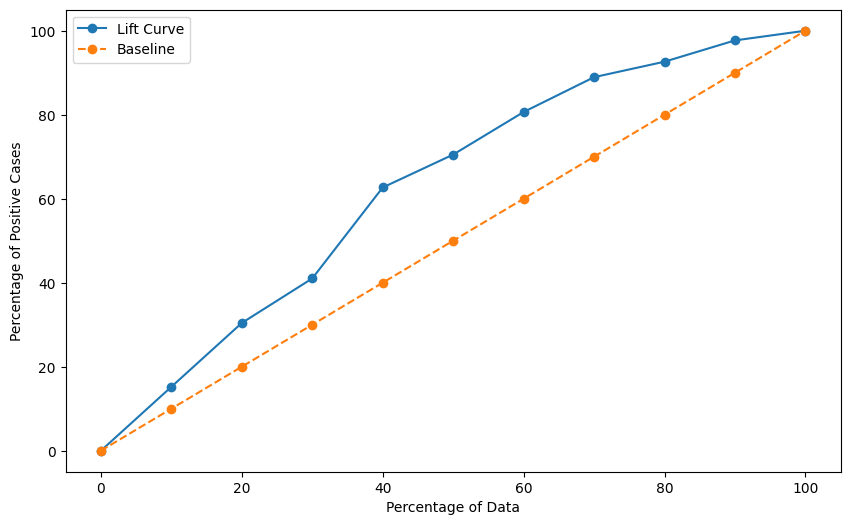

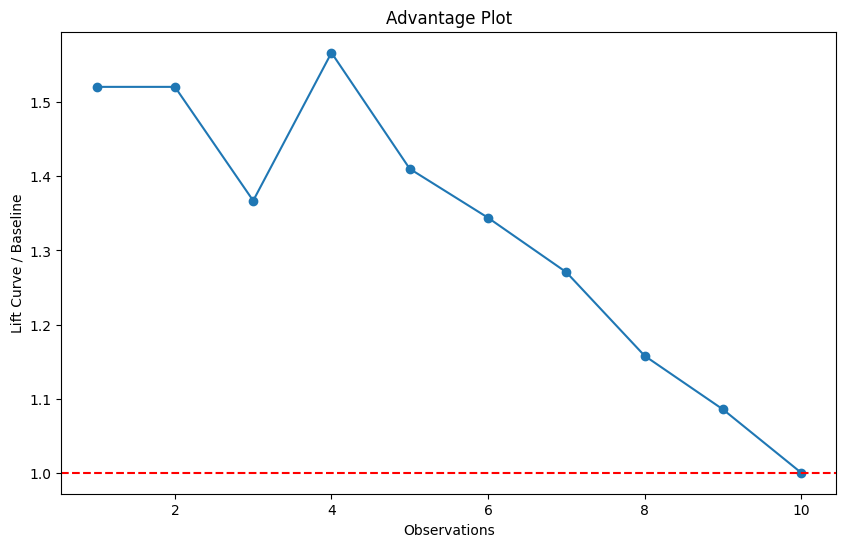


Top 10 observations by predicted probability:


,target,predicted_probs
1405,0,0.579455
279,1,0.562695
2586,1,0.560023
3331,1,0.558055
1211,1,0.551534
184,0,0.550060
3379,0,0.546820
893,0,0.541995
2682,0,0.539455
63,0,0.533752



Bottom 10 observations by predicted probability:


,target,predicted_probs
3284,0,0.029019
976,0,0.028952
2335,0,0.028776
1532,0,0.023675
1916,0,0.022613
538,0,0.022580
990,0,0.019946
3594,0,0.017780
3052,0,0.016003
2476,0,0.010245


In [115]:
best_terms = results_df.iloc[0]['interactions']

X = data[base_features].copy()
for t1, t2 in best_terms:
    X[f'{t1}_{t2}'] = X[t1] * X[t2]

y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
y_pred_proba_test = model.predict(sm.add_constant(X_test))

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)

total_pos = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)
deciles = np.linspace(0, n_rows, 11, dtype=int)
lift_curve = [test_data_sorted.iloc[:i]['target'].sum() / total_pos * 100 for i in deciles]
baseline = np.linspace(0, 100, 11)

print(f'Yield at 40%: {lift_curve[4]:.1f}%')

plt.figure(figsize=(10, 6))
plt.plot(baseline, lift_curve, marker='o', label='Lift Curve')
plt.plot(baseline, baseline, linestyle='--', marker='o', label='Baseline')
plt.xlabel('Percentage of Data')
plt.ylabel('Percentage of Positive Cases')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(11), np.array(lift_curve) / baseline, marker='o')
plt.axhline(y=1, linestyle='--', color='r')
plt.xlabel('Observations')
plt.ylabel('Lift Curve / Baseline')
plt.title('Advantage Plot')
plt.show()

print("\nTop 10 observations by predicted probability:")
display(test_data_sorted.head(10))

print("\nBottom 10 observations by predicted probability:")
display(test_data_sorted.tail(10))


If the advantage chart shows that from left to right the curve is directly least to greatest advantage then the model is as optimized as possible 